In [36]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from scripts import MONGO_URL
from scripts.analysis import data, plot

plot.init_matplotlib()
W, H = 5.5, 2.5


def pad_missing_months(ts: pd.Series) -> pd.Series:
    start, end = ts.index[0], ts.index[-1]
    all_months = map(
        lambda month: month.strftime("%Y-%m"),
        pd.date_range(start=start, end=end, freq="MS"),
    )
    return ts.reindex(all_months, fill_value=0)


def aggreagte_user_ts(fake_type: str, repo_months: set[tuple[str, str]]) -> pd.Series:
    assert fake_type in ["low_activity", "clustered"]
    client = pymongo.MongoClient(MONGO_URL)
    ts_users = pd.Series(
        Counter(
            filter(
                lambda x: x in (x[1] for x in repo_months),
                map(
                    lambda x: x["starred_at"][:7],
                    list(
                        client.fake_stars[f"{fake_type}_stars"].find(
                            {
                                "repo": {"$in": [x[0] for x in repo_months]},
                                fake_type: True,
                            }
                        )
                    ),
                ),
            )
        )
    ).sort_index()
    client.close()
    return pad_missing_months(ts_users)

In [ ]:
repo_with_campaign = data.get_repos_with_campaign()
stars_by_month = data.get_fake_stars_by_month()
stars_by_month = stars_by_month[stars_by_month.month != "2024-10"]

In [99]:
ts_real = pd.read_csv("data/all_github_stars_by_month.csv").set_index("month")[
    "n_stars"
]
ts_fake = stars_by_month.groupby("month").sum()[
    ["n_stars_low_activity", "n_stars_clustered"]
]
ts_repos = pad_missing_months(
    stars_by_month[stars_by_month.anomaly].groupby("month").count()[["repo"]]
)
repo_months = set(
    stars_by_month[stars_by_month.anomaly][["repo", "month"]].apply(tuple, axis=1)
)
ts_users_low_activity = aggreagte_user_ts("low_activity", repo_months)
ts_users_clustered = aggreagte_user_ts("clustered", repo_months)

month
2024-05    0.047792
2024-06    0.112543
2024-07    0.102646
2024-08    0.082854
2024-09    0.051155
dtype: float64
month
2024-05    293053.0
2024-06    715243.0
2024-07    729723.0
2024-08    511644.0
2024-09    299210.0
dtype: float64


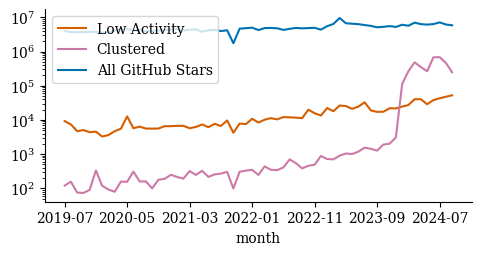

In [122]:
fig, ax = plt.subplots(1, 1, figsize=(W, H))
ts_fake.plot(kind="line", ax=ax, color=["C2", "C3"])
ts_real.plot(kind="line", ax=ax, color="C0")
ax.set_yscale("log")
ax.legend(loc="upper left", labels=["Low Activity", "Clustered", "All GitHub Stars"])
plot.remove_spines(ax)
fig.savefig("plots/ts_stars.pdf", bbox_inches="tight")

percentage = (
    ts_fake.n_stars_low_activity + ts_fake.n_stars_clustered
) / ts_real
print(percentage.tail())
print((ts_fake.n_stars_low_activity + ts_fake.n_stars_clustered).tail())

month
2024-05    0.090386
2024-06    0.158271
2024-07    0.153121
2024-08    0.098314
2024-09    0.085623
Name: repo, dtype: float64
         repo
month        
2024-05  1303
2024-06  2504
2024-07  3216
2024-08  1429
2024-09  1178


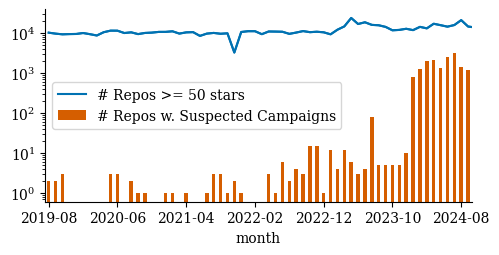

In [121]:
all_spiky_repos = pd.read_csv("data/all_github_repos_with_spikes.csv")
all_spiky_repos = all_spiky_repos.groupby("month").count()

fig, ax = plt.subplots(1, 1, figsize=(W, H))
ts_repos.plot(kind="bar", ax=ax, color="C2")
all_spiky_repos.plot(kind="line", ax=ax, color="C0")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=["# Repos >= 50 stars", "# Repos w. Suspected Campaigns"])
ax.set_yscale("log")
ax.set_xticks(range(0, len(ts_repos), 10))
ax.set_xticklabels(ts_repos.index[::10])
plot.remove_spines(ax)
fig.savefig("plots/ts_repos.pdf", bbox_inches="tight")

percentage = ts_repos.repo.divide(all_spiky_repos["repo"])
print(percentage.tail())
print(ts_repos.tail())

2024-05    0.028525
2024-06    0.085305
2024-07    0.080845
2024-08    0.062794
2024-09    0.034815
dtype: float64
2024-05    174912
2024-06    542138
2024-07    574733
2024-08    387770
2024-09    203634
dtype: int64


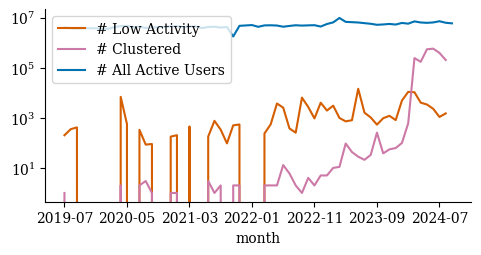

In [124]:
ts_users = (
    pd.read_csv("data/all_github_users_by_month.csv")
    .set_index("month")["n_active_users"]
    .sort_index()
)

percentage = (ts_users_low_activity + ts_users_clustered) / ts_users
print(percentage.tail())
print((ts_users_low_activity + ts_users_clustered).tail())

fig, ax = plt.subplots(1, 1, figsize=(W, H))
ts_users_low_activity.plot(kind="line", ax=ax, color="C2")
ts_users_clustered.plot(kind="line", ax=ax, color="C3")
ts_users.plot(kind="line", ax=ax, color="C0")
ax.set_yscale("log")
ax.legend(
    loc="upper left", labels=["# Low Activity", "# Clustered", "# All Active Users"]
)
plot.remove_spines(ax)
fig.savefig("plots/ts_users.pdf", bbox_inches="tight")